# Deep Learning for Audio Part 1 - Audio Processing

The purpose of this notebook is to outline how to preprocess audio data for machine learning, including deep learning approaches, i.e. how would one would generate audio or proceed from an audio recording to a featurized dataset which can be used to train a machine learning model. We also cover some background on audio processing theory which is needed to perform such featurization.

In [ ]:
# change notebook settings for wider screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Featurization

Before we can perform data science on audio signals we have to first convert them to a format which is useful - this process is called featurization, i.e. we create features from each sound file. We later combine multiple sound files together into train, validation and test sets used by the machine learning algorithm.

### Audio features demystified

Audio by itself comes in amplitude representation, where amplitude of the sound changes at a certain frequency over time. What we need to do is extract what frequencies are present in each unit of time - those frequencies, when combined, create sounds. Think of playing piano notes - each note resonates at a particular frequency and those frequencies combine to create a particular tune. If we know what notes are being played, we can attempt to classify a particular piano solo. Hence we need a mechanism of breaking down amplitude over time over frequencies over time: such representation is also commonly called a _spectrogram_.

Luckily for us, there is a [Fast Fourier Transform algorithm](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (FFT) which does just that: it converts amplitude over each time segment into corresponding frequencies. There is another [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) which states that if we sample the incoming sound signal at a certain rate, we can achieve what's commonly called **"lossless"** audio, i.e. we can convert amplitude into frequencies over time and then recover the original amplitude with no error at any point of time from the broken down frequencies.

#### Nyquist Theorem and frequencies

If the highest frequency component in a signal is f<sub>max</sub>, then the sampling rate must be at least 2f<sub>max</sub>. The higher the highest frequency, the higher the _bandwidth_ of the signal. 

### Toy Example

We simulate the simplest type of audio signal there is - a simple sine wave at a particular frequency. To make things interesteding, we generate two such sine waves at different frequencies and add them together - we expect to recover just those two frequencies in the spectrogram.

You'll see in the next notebook that real world examples are usually far more complex than what we're showing here - there are multiple overlapping frequencies. Given the Nyquist Theorem, we have to make sure that we sample at at least twice the rate of the highest frequency that we intend to detect in the signal. To do this, the [bitrate](https://en.wikipedia.org/wiki/Bit_rate#Audio) of the sample audio has to be high enough to allow us to do this, i.e. the number of discrete time points per 1 second of audio length. 

Since we're generating sample audio in this notebook, we get to control all these parameters, however when working with different audio formats you have to be aware of all the theory behind audio storage: for example, reduction in bandwitch affects the sampling frequency which in turn affects the maximum frequency (and bandwidth) which you can train on; other audio formats cut out non-dominant frequencies from the file entirely to reduce storage size.


You can change the two frequencies below to whichever number you want - as long as you make sure that the bitrate is higher than the maximum frequency.

In [17]:
import math
import numpy as np

# in Hertz, so 32kHz
bitrate = 32000

# note frequencies https://pages.mtu.edu/~suits/notefreqs.html
freq1 = 512.
freq2 = 1024.
assert(freq1 > 0 and freq2 > 0)

sound_clip_duration = 1     #seconds to play sound

# increase sound quality rate to represent underlying frequencies
if max(freq1, freq2) > bitrate:
    bitrate = max(freq1, freq2) + 100.

# number of time series points in the array
n = int(bitrate * sound_clip_duration)
# pad the sound time series
n_pad = n % bitrate

# pad the series
x = np.arange(n)
# use np.sin instead of vectorizing sin
# vector_sin = np.vectorize(lambda arg: math.sin(arg))
wave_fun = lambda freq: np.sin(x/((bitrate/freq)/math.pi))
# superposition of two frequencies
data_array = wave_fun(freq1) + wave_fun(freq2)
# renormalize the data (to guarantee sine wave for playback later on)
data_array /= np.abs(data_array).max()
# pad the array with zeros if needed
data_array = np.hstack((data_array, np.zeros(n_pad)))

# final sanity check
assert(n + n_pad == len(data_array))


Now that we've generated the audio stream, we can try playing it (if your machine has audio access - if not, next section records a .wav file which you can play on any machine).

In [18]:
# run the following command if PyAudio is not installed on your machine
# sudo apt-get install python-pyaudio
# sudo apt install libasound-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg libav-tools
# pip install pyaudio
import pyaudio     
PyAudio = pyaudio.PyAudio     #initialize pyaudio

data = ''
#generating waves
for i in range(n + n_pad):    
    data += chr(int(data_array[i]*127+128))

p = PyAudio()
stream = p.open(format = p.get_format_from_width(1), 
                channels = 1, 
                rate = bitrate, 
                output = True)

stream.write(data)
stream.stop_stream()
stream.close()
p.terminate()


### Working with different audio formats

Not all audio formats are lossless - as described in the previous section, some try to reduce the overall file size by the use of algorithms, which may degrade sound quality, thereby affecting the featurization and the quality of your predictions on the test set. For example, one common approach which can reduce the size of the audio file is to eliminate non-dominant frequencies and store the file as a sparser spectrogram - the decoder converts the sparser spectrogram back into audio waveform when playing the file; one can further reduce file size by downsampling the original waveform before computing the spectrogram - as we know from the previous section, both approaches will degrade sound quality and some events might become undetectable from the audio data (no matter which algorithm you use).

We detail how to work with .wav file format in this notebook, which is the most common lossless file format for audio work. We recommend you convert any other file format to .wav if you want to re-apply this notebook to other datasets on DS VM.

[Python Audio Tools](http://audiotools.sourceforge.net/install.html) provide a great way to handle conversions between various file formats (and can even rip entire CDs of music).

We use the wave library to save the python audio stream as a sequence of byte frames:

In [19]:
import wave
import os
test_fname = os.getcwd() + "/test.wav"
print ("Saving file to " + test_fname)

wave_file = wave.open(test_fname, 'wb')
# mono audio
wave_file.setnchannels(1)
wave_file.setsampwidth(p.get_sample_size(pyaudio.paInt16))
wave_file.setframerate(bitrate)
wave_file.writeframesraw(bytes(data, 'UTF-8'))
wave_file.close()


Saving file to /home/maxkaz/AudioDemo/GoogleCommands/test.wav


You can now download the sample audio file and play it on your computer.

Next, we need to perform the FFT decomposition and recover the original frequencies which we've introduced.

In [20]:
# this has to be at least twice of max frequency which we've entered
# but you can play around with different sample rates and see how this
# affects the results;
# since we generated this audio, the sample rate is the bitrate
sample_rate = bitrate

# size of audio FFT window relative to sample_rate
n_window = 1024
# overlap between adjacent FFT windows
n_overlap = 360
# number of mel frequency bands to generate
n_mels = 64

# fmin and fmax for librosa filters in Hz - used for visualization purposes only
fmax = max(freq1, freq2) + 1000.
fmin = 0.

# stylistic change to the notebook
fontsize = 14


The section below visualizes the sound which we generated (and saved to disk), plots the mel-scaled FFT (also known as [Mel spectrogram](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) or Short Mel FFT) and then plots an alternative spectrogram in log-domain which we use for featurization for the neural network.

#### Wave plot

This shows two normalized and added sine waves which we generated. You see predominantly two oscillations which we've introduced - pretty simple.

#### Mel spectrogram

This is simply the FFT of each audio chunk (defined by sliding window) mappled to [mel scale](https://en.wikipedia.org/wiki/Mel_scale), which perceptually makes pitches to be of equal distance from one another (human ear focuses on certain frequencies, so our perception is that the mel frequencies are of equal distance from each other and not the raw FFT frequencies) - think of changing the FFT frequency scale to make sure all features (frequencies) are equidistant. __Here you can clearly see that we recovered the original frequencies which we entered at the beginning of this notebook with no loss__.

We need to add a few extra steps to use the spectrogram for [audio event detection](http://www.cs.tut.fi/sgn/arg/dcase2017/index):
- after mapping the frequencies to mel-scale, we use the [Hamming window](https://en.wikipedia.org/wiki/Window_function#Hamming_window) in the FFT: the assumption is that time domain signal is periodic which results in discontinuity at the edges of the FFT window (chunk). Window functions are designed to avoid this, by making sure that the data at the edges is zero (no discontinuity). This is achieved by multiplying the signal by the window function (Hamming in this case) which gradually decays the signal towards zero at the edges.
 - we use a mel filter matrix to combine FFT bins into mel frequency bins: this step is equivalent to the pervious step where use used canned _librosa_ routine, given the same windowing function is used by librosa
 - we further make sure that there are no numerical problems in taking the logarithm of the FFT by adding a small positive number (offset) to the FFT before taking the log. The logarithm of the mel-scaled spectrogram is used directly for acoustic event detection.
 
This is the raw featurization which is needed to detect acoustic events in audio (e.g. dog barking, water boiling, tires screeching), which is our ultimate goal. For human speech recognition systems this featurization is not usually used directly.

#### Speech recognition approaches

In speech recognition (and speaker detection), human brains tend to focus on lower-frequency patterns in audio, so the featurization approach needs to go a step further and compute [Mel Frequency Cepstral Coefficients (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). The idea is simple - we want to fit an envelope function across the log of the mel-scaled frequencies. To do this, we use the [Discrete Cosine Transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform):
 - we compute the DCT of the log of mel-scaled frequency spectrogram
 - we then use Cepstral Analysis to focus on the lower frequencies, which give us the envelope and the MFCCs which we then directly train on for speech recognition - MFCCs are the amplitudes of the resulting spectrum
 
Basically the log mel frequency spectrogram can be thought of as the sum of the spectral envelope (slow and steady function) and spectral details (remaining residual). Since humans tend to focus on patterns in lower frequencies, we are more interested in the former - the spectral envelope. Because we have access to the sum and not each element, we use the DCT to obtain the cepstrum and then focus on the coefficients which are responsible for modelling lower frequencies - more details are provided [here](http://www.speech.cs.cmu.edu/15-492/slides/03_mfcc.pdf).

It should also be noted that there are other approaches for speech recognition - in the next notebook we actually obtain great performance on speech commands dataset without the use of MFCCs.

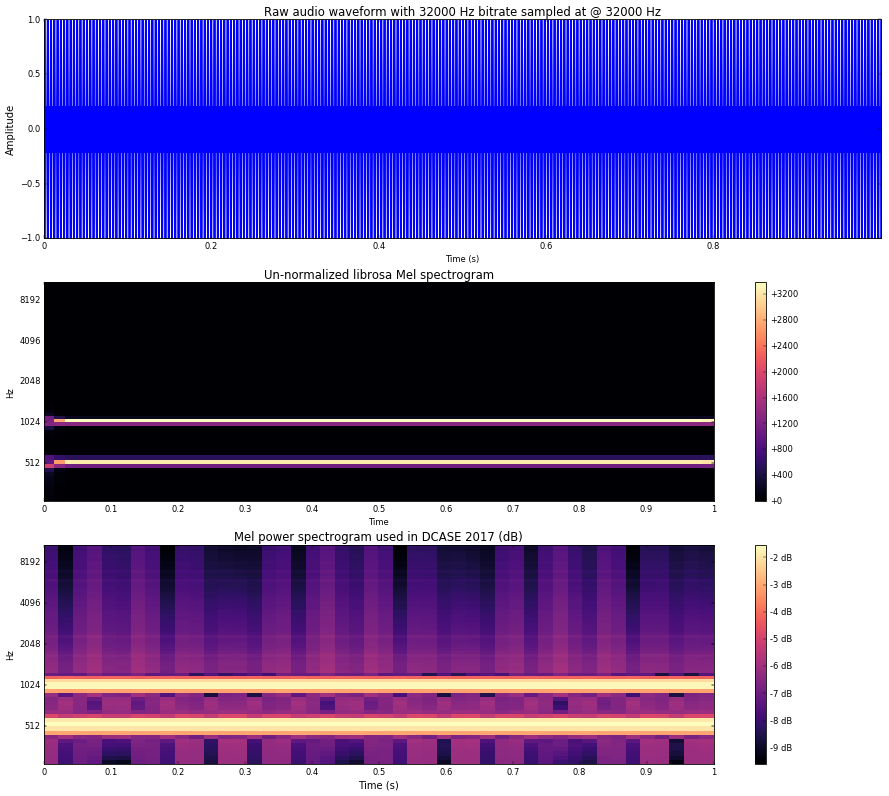

In [21]:
# set plotting parameters
%matplotlib inline
import matplotlib.pyplot as plt
# third-party sounds processing and visualization library
import librosa
import librosa.display
# signal processing library
from scipy import signal

# Make a new figure
plt.figure(figsize=(16, 16), dpi= 60, facecolor='w', edgecolor='k')
plt.subplot(311)
# display the raw waveform
librosa.display.waveplot(data_array, int(sample_rate), max_sr = int(sample_rate))
plt.title('Raw audio waveform with %d Hz bitrate sampled at @ %d Hz' % (int(bitrate), int(sample_rate)), fontsize = fontsize) 
plt.xlabel("Time (s)")
plt.ylabel("Amplitude", fontsize = 'large')

plt.subplot(312)
S = librosa.feature.melspectrogram(data_array, sr = sample_rate, n_mels=n_mels, fmin = fmin, fmax = fmax)
#S = librosa.feature.spectral.fft_frequencies(data_array, sample_rate)
# Convert to log scale (dB). We'll use the peak power as reference.
# log_S = librosa.logamplitude(S, ref_power=np.max)
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(S, sr = sample_rate, x_axis = 'time', y_axis='mel',\
                         x_coords=np.linspace(0, 1, S.shape[1]))
# optional colorbar plot
plt.colorbar(format='%+02.0f')
plt.title('Un-normalized librosa Mel spectrogram', fontsize = fontsize)

plt.subplot(313)
melW = librosa.filters.mel(sr=sample_rate, n_fft=n_window, n_mels=64, fmin=fmin, fmax=fmax)
ham_win = np.hamming(n_window)
[f, t, x] = signal.spectral.spectrogram(
    x=data_array,
    window=ham_win,
    nperseg=n_window,
    noverlap=n_overlap,
    detrend=False,
    return_onesided=True,
    mode='magnitude')
x = np.dot(x.T, melW.T)
x = np.log(x + 1e-8)
x = x.astype(np.float32)
librosa.display.specshow(x.T, sr=sample_rate, x_axis='time', y_axis='mel', x_coords=np.linspace(0, 1, x.shape[0]))
plt.xlabel("Time (s)", fontsize = 'large')
plt.title("Mel power spectrogram used in DCASE 2017 (dB)", fontsize = fontsize)
# optional colorbar plot
plt.colorbar(format='%+02.0f dB')


# Make the figure layout compact
# plt.tight_layout()

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


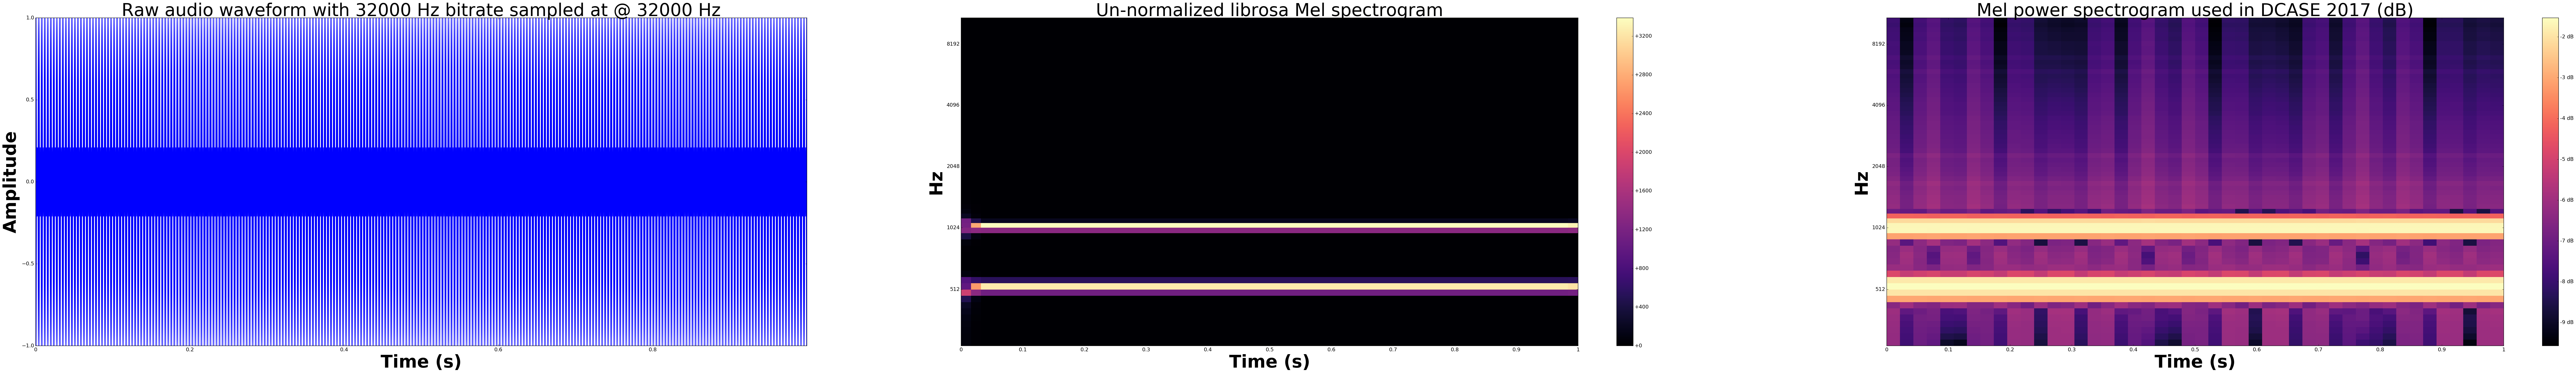

In [30]:
# set plotting parameters
fontsize_blog = 48
%matplotlib inline
import matplotlib.pyplot as plt
# third-party sounds processing and visualization library
import librosa
import librosa.display
# signal processing library
from scipy import signal

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['figure.titlesize'] = fontsize

# Make a new figure
plt.figure(figsize=(128, 16), dpi= 120, facecolor='w', edgecolor='k')
plt.subplot(131)
# display the raw waveform
librosa.display.waveplot(data_array, int(sample_rate), max_sr = int(sample_rate))
plt.title('Raw audio waveform with %d Hz bitrate sampled at @ %d Hz' % (int(bitrate), int(sample_rate)), fontsize = fontsize_blog)
plt.xlabel("Time (s)", fontsize = fontsize_blog)
plt.ylabel("Amplitude", fontsize = fontsize_blog)

plt.subplot(132)
S = librosa.feature.melspectrogram(data_array, sr = sample_rate, n_mels=n_mels, fmin = fmin, fmax = fmax)
#S = librosa.feature.spectral.fft_frequencies(data_array, sample_rate)
# Convert to log scale (dB). We'll use the peak power as reference.
# log_S = librosa.logamplitude(S, ref_power=np.max)
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(S, sr = sample_rate, x_axis = 'time', y_axis='mel',\
                         x_coords=np.linspace(0, 1, S.shape[1]))
# optional colorbar plot
plt.colorbar(format='%+02.0f')
plt.title('Un-normalized librosa Mel spectrogram', fontsize = fontsize_blog)
plt.xlabel("Time (s)", fontsize = fontsize_blog)
plt.ylabel("Hz", fontsize = fontsize_blog)

plt.subplot(133)
melW = librosa.filters.mel(sr=sample_rate, n_fft=n_window, n_mels=64, fmin=fmin, fmax=fmax)
ham_win = np.hamming(n_window)
[f, t, x] = signal.spectral.spectrogram(
    x=data_array,
    window=ham_win,
    nperseg=n_window,
    noverlap=n_overlap,
    detrend=False,
    return_onesided=True,
    mode='magnitude')
x = np.dot(x.T, melW.T)
x = np.log(x + 1e-8)
x = x.astype(np.float32)
librosa.display.specshow(x.T, sr=sample_rate, x_axis='time', y_axis='mel', x_coords=np.linspace(0, 1, x.shape[0]))
plt.xlabel("Time (s)", fontsize = fontsize_blog)
plt.ylabel("Hz", fontsize = fontsize_blog)
plt.title("Mel power spectrogram used in DCASE 2017 (dB)", fontsize = fontsize_blog)
# optional colorbar plot
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
# plt.tight_layout()

In [27]:
librosa.display.specshow?

## Featurization on DS VM

Next section shows how to handle input .wav file and featurize it to useful spectrogram - there are four plots:
1. Shows the original amplitude plot of the .wav file. The Google Speech Commands data has already been converted to mono sound representation, so instead of two amplitudes over time (stereo) we get only one single audio amplitude (sound) as a function of time over a 1-second interval.
2. Here we show the fastest and easiest way to get started with audio data - a "_librosa_" spectrogram. This is achieved with most common out-of-the-box settings with librosa which should be enough for you to get started with your own audio data.
3. We reduce the size of the sampling window to purposely oversample the audio time series, i.e. we increase the resolution of the spectrogram, but don't have enough observations in each time window  - this effectively causes us to miss certain frequencies, which we see as black lines in the spectrogram.
4. We re-apply the approach from the winning DCASE 2017 Task 4 solution - this shows the approach which is used to featurize the data for machine learning in the rest of the notebook. As you can see, the featurized dataset isn't very different from out-of-the-box solution provided by generic application of librosa library.


In [7]:
# TODO: download file from blob or add to DS VM image
data_dir = "/home/maxkaz/Downloads/"
audio_path = data_dir + '/zero/004ae714_nohash_0.wav'
sample_rate = 16000

In [20]:
# audio is a 1D time series of the sound
# can also use (audio, fs) = soundfile.read(audio_path)
(audio, fs) = librosa.load(audio_path, sr = None, duration = 1)
# check that native bitrate matches our assumed sample rate
assert(int(fs) == int(sample_rate))

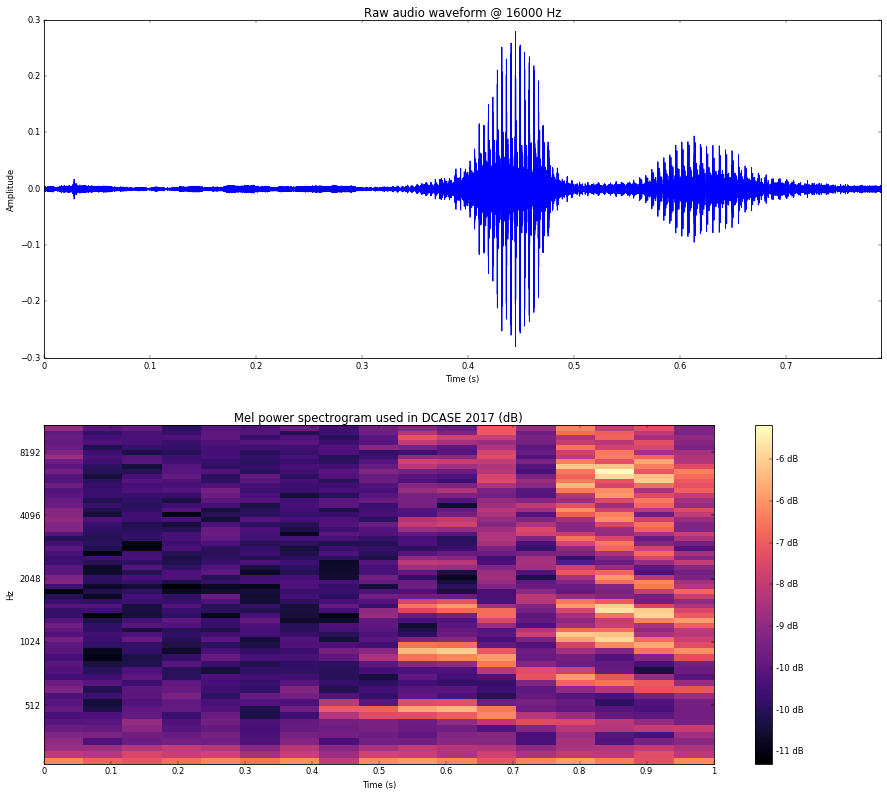

In [22]:
# Make a new figure
plt.figure(figsize=(18, 16), dpi= 60, facecolor='w', edgecolor='k')
plt.subplot(211)
# Display the spectrogram on a mel scale
librosa.display.waveplot(audio, int(sample_rate), max_sr = int(sample_rate))
plt.title('Raw audio waveform @ %d Hz' % sample_rate, fontsize = fontsize) 
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(212)
melW =librosa.filters.mel(sr=sample_rate, n_fft=n_window, n_mels=n_mels, fmin=fmin, fmax=fmax)
ham_win = np.hamming(n_window)
[f, t, x] = signal.spectral.spectrogram(
    x=audio,
    window=ham_win,
    nperseg=n_window,
    noverlap=n_overlap,
    detrend=False,
    return_onesided=True,
    mode='magnitude')
x = np.dot(x.T, melW.T)
x = np.log(x + 1e-8)
x = x.astype(np.float32)
librosa.display.specshow(x.T, sr=sample_rate, x_axis='time', y_axis='mel', x_coords=np.linspace(0, 1, x.shape[0]))
plt.xlabel("Time (s)")
plt.title("Mel power spectrogram used in DCASE 2017 (dB)", fontsize = fontsize)
# optional colorbar plot
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
# plt.tight_layout()

## Advanced concepts

### Negative set and active learning

When performing classification it's important to define a so-called _negative_ set. For example, in traditional classification if we're trying to classify some input as mapping to N classes, we just train on those N classes. But say you want to detect all cars and boats in a particular panoramic image, i.e. once you localize your attention to all objects which you think could be a car or a boat (this is currently accomplished with the use of [Fast R-CNN](https://docs.microsoft.com/en-us/cognitive-toolkit/object-detection-using-fast-r-cnn)), you need to finally classify whether the image is actually a car, a boat, or neither (a simpler alternative over Fast R-CNN, which performs the same task, is given [here](https://blogs.technet.microsoft.com/machinelearning/2016/10/31/applying-cloud-deep-learning-at-scale-with-microsoft-r-server-azure-data-lake/)). The problem is complicated by the fact that the image contains a certain background, which can bias the classification - for example, if cars in the training set were all shot in front of an ocean or a river and the test set has the car in an urban environment, the algorithm might fail to recognize that it's a car and will default to "neither"; by the same token, some cars could have been parked in front of boats in the test set, and the algorithm might incorrectly classify that a car in front of a boat is a boat. To avoid these situations, it's common to create a negative set with all these cases as examples - so training set is inflated with a negative set where we add samples of what we don't want it to classify as a car or a boat, i.e. parts of boats, parts of cars, urban environments, etc. We further add positive reinforcement by increasing the size of the positive sets (cars, boats, etc) with additional examples, for instance cars packed in an urban environment are still cars, cars parked in front of boats are still cars, etc. The process of adding positive reinforcement examples is commonly known as _"active learning"_ in the vision domain.

The benefit of having a large negative set can be substantial when you start evaluating the performance of your trained model. Adding positive reinforcement samples through the process of active learning will further improve the performance of the model.

We can draw the same analogy to audio processing, since the spectrogram can be thought of as an image and then same concepts apply. In the context of this notebook, since we are trying to classify individual commands, any command which is not part of the command which we want to classify automatically gets added to the negative set, along with background noise. We can further generate more positive examples by adding various background noises to the original commands if we notice that they are not being classified correctly - this is our audio equivalent to active learning.
